In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/GANs'

In [61]:
%cd '/content/drive/MyDrive/GANs'

/content/drive/MyDrive/GANs


In [62]:
!pwd

/content/drive/MyDrive/GANs


In [63]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
%matplotlib inline

In [64]:
def get_uniform(batch_size):
  return torch.rand(batch_size, 1)

In [65]:
def get_normal(batch_size):
  return torch.randn(batch_size, 1) + 5

In [66]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
        nn.Linear(in_features=1, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=1)
    )

  def forward(self, x):
    return self.main(x)

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
        nn.Linear(in_features=1, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.main(x)

gen = Generator()
disc = Discriminator()

In [67]:
generator_opt = torch.optim.SGD(gen.parameters(), lr = 1e-3)
discriminator_opt = torch.optim.SGD(disc.parameters(), lr = 1e-3)

In [68]:
def update_D(batch_size):
  real_samples = get_normal(batch_size)
  prob_real_is_real = disc(real_samples)

  noise = get_uniform(batch_size)
  generated_samples = gen(noise)
  prob_fake_is_fake = 1 - disc(generated_samples)

  loss = (-torch.log(prob_real_is_real)- torch.log(prob_fake_is_fake)).mean()

  discriminator_opt.zero_grad()
  loss.backward()
  discriminator_opt.step()

  return loss.data.numpy().item()

In [69]:
def update_G(batch_size):
  noise = get_uniform(batch_size)
  generated_samples = gen(noise)
  prob_fake_is_real = disc(generated_samples)

  loss = (-torch.log(prob_fake_is_real)).mean()

  generator_opt.zero_grad()
  loss.backward()
  generator_opt.step()

  return loss.data.numpy().item()

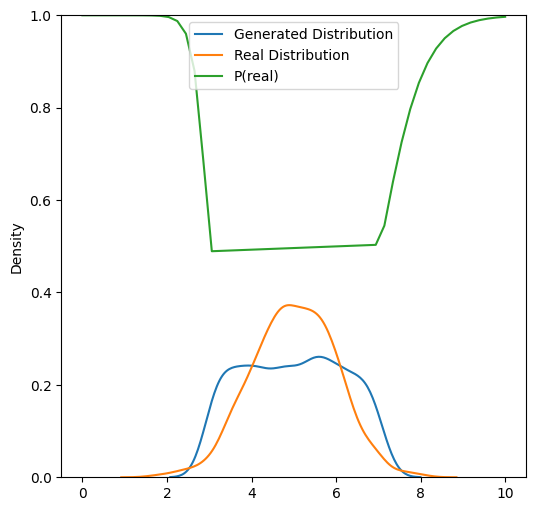

In [ ]:
N_DISC_OPERATIONS = 50
BATCH_SIZE = 64

for i in range(10000):

  for _ in range(N_DISC_OPERATIONS):
    update_D(BATCH_SIZE)

  update_G(BATCH_SIZE)

  if i % 300 == 0:
    clear_output(True)
    plt.figure(figsize=[6,6])

    sns.kdeplot(gen(get_uniform(1000)).data.numpy()[:,0], label = "Generated Distribution")
    sns.kdeplot(get_normal(1000).data.numpy()[:,0], label = "Real Distribution")

    x = np.linspace(0,10,dtype="float32")
    p_real = disc(torch.from_numpy(x[:, None]))
    plt.plot(x, p_real.data.numpy(), label = "P(real)")

    axes = plt.gca()
    axes.set_ylim([0,1])

    plt.legend()
    plt.show()